<a href="https://colab.research.google.com/github/dblakney0895/Financial-Transaction-Fraud-Risk-Analysis/blob/main/Copy_of_fraud_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Transaction Fraud Risk Analysis

## Executive Summary

This project analyzes synthetic financial transaction data to explore fraud patterns and evaluate a rule-based risk scoring model.

Key outcomes:

- Fraud rate: ~1% (realistic class imbalance)
- Fraud risk increases with international transactions, high merchant risk, late-night activity, and new accounts
- Lower decision thresholds significantly increase recall but raise false positives
- Demonstrates the operational tradeoff between fraud detection and customer experience

This case study illustrates fraud analytics workflow including data simulation, feature engineering, exploratory analysis, risk scoring, threshold evaluation, and business interpretation.


## 1. Data Simulation


In [ ]:


import numpy as np
import pandas as pd

np.random.seed(42)
n = 15000

df = pd.DataFrame({
    "transaction_id": np.arange(1, n+1),
    "amount": np.round(np.random.lognormal(mean=3.3, sigma=0.8, size=n), 2),
    "hour": np.random.randint(0, 24, size=n),
    "is_international": np.random.binomial(1, 0.08, size=n),
    "is_card_present": np.random.binomial(1, 0.75, size=n),
    "merchant_risk_score": np.random.randint(1, 101, size=n),
    "account_age_days": np.random.randint(1, 3650, size=n),
    "txn_count_24h": np.random.poisson(lam=2.5, size=n),
})

risk = (
    0.002
    + 0.010 * (df["amount"] > 250).astype(int)
    + 0.015 * (df["amount"] > 800).astype(int)
    + 0.020 * (df["is_international"] == 1).astype(int)
    + 0.012 * (df["is_card_present"] == 0).astype(int)
    + 0.015 * (df["merchant_risk_score"] > 80).astype(int)
    + 0.010 * (df["txn_count_24h"] > 6).astype(int)
    + 0.010 * (df["account_age_days"] < 60).astype(int)
    + 0.006 * ((df["hour"] <= 4) | (df["hour"] >= 23)).astype(int)
)

risk = np.clip(risk, 0, 0.35)
df["is_fraud"] = (np.random.rand(n) < risk).astype(int)

df.head(), df["is_fraud"].mean()

(   transaction_id  amount  hour  is_international  is_card_present  \
 0               1   40.34    16                 0                1   
 1               2   24.27     7                 0                1   
 2               3   45.52    17                 0                1   
 3               4   91.69    14                 0                1   
 4               5   22.48    14                 0                1   
 
    merchant_risk_score  account_age_days  txn_count_24h  is_fraud  
 0                   13              2507              0         0  
 1                   94              1296              2         0  
 2                   88              1915              3         0  
 3                   98               417              2         0  
 4                   37              2368              2         0  ,
 np.float64(0.009866666666666666))

## 2. Exploratory Data Analysis
We examine fraud prevalence and key transaction characteristics to understand patterns in the data.


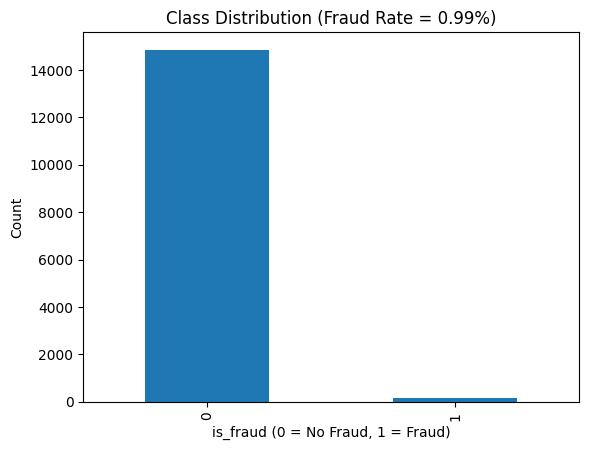

In [ ]:
import matplotlib.pyplot as plt

fraud_rate = df["is_fraud"].mean()
counts = df["is_fraud"].value_counts().sort_index()

plt.figure()
counts.plot(kind="bar")
plt.title(f"Class Distribution (Fraud Rate = {fraud_rate:.2%})")
plt.xlabel("is_fraud (0 = No Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

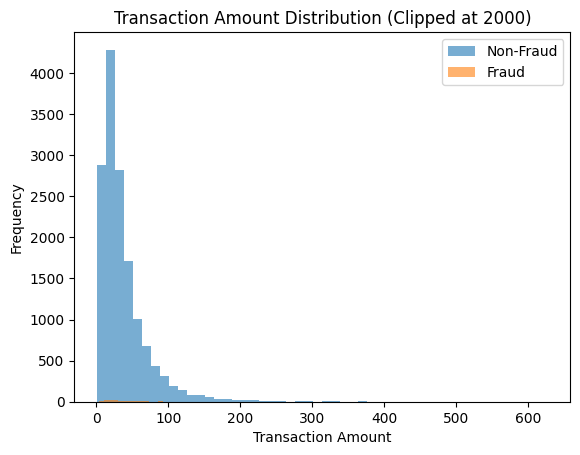

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,14852.0,37.440304,35.591990,1.18,15.8875,27.16,46.4325,627.03
1,148.0,39.430000,41.643454,4.67,17.2275,26.11,46.6725,318.34


In [ ]:
plt.figure()

df[df["is_fraud"]==0]["amount"].clip(upper=2000).plot(
    kind="hist", bins=50, alpha=0.6, label="Non-Fraud"
)

df[df["is_fraud"]==1]["amount"].clip(upper=2000).plot(
    kind="hist", bins=50, alpha=0.6, label="Fraud"
)

plt.title("Transaction Amount Distribution (Clipped at 2000)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

df.groupby("is_fraud")["amount"].describe()


## 3. Rule-Based Risk Scoring Model


In [ ]:
# Create simple, explainable risk score

df["risk_score"] = (
    20 * (df["amount"] > 250).astype(int)
    + 30 * (df["amount"] > 800).astype(int)
    + 25 * df["is_international"]
    + 20 * (df["is_card_present"] == 0).astype(int)
    + 25 * (df["merchant_risk_score"] > 80).astype(int)
    + 15 * (df["txn_count_24h"] > 6).astype(int)
    + 15 * (df["account_age_days"] < 60).astype(int)
    + 10 * (((df["hour"] <= 4) | (df["hour"] >= 23)).astype(int))
)

df[["risk_score", "is_fraud"]].head()


,risk_score,is_fraud
0,0,0
1,25,0
2,25,0
3,25,0
4,0,0


## 4. Threshold Analysis and Model Evaluation


In [ ]:
threshold = 60
df["flagged"] = (df["risk_score"] >= threshold).astype(int)

tp = ((df["flagged"]==1) & (df["is_fraud"]==1)).sum()
fp = ((df["flagged"]==1) & (df["is_fraud"]==0)).sum()
fn = ((df["flagged"]==0) & (df["is_fraud"]==1)).sum()

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))


True Positives: 3
False Positives: 123
False Negatives: 145
Precision: 0.024
Recall: 0.02


In [ ]:
threshold = 40
df["flagged"] = (df["risk_score"] >= threshold).astype(int)

tp = ((df["flagged"]==1) & (df["is_fraud"]==1)).sum()
fp = ((df["flagged"]==1) & (df["is_fraud"]==0)).sum()
fn = ((df["flagged"]==0) & (df["is_fraud"]==1)).sum()

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))


True Positives: 41
False Positives: 1267
False Negatives: 107
Precision: 0.031
Recall: 0.277


## Key Findings

- Fraud rate in dataset: ~1%, demonstrating realistic class imbalance
- Fraud transactions show slightly higher transaction amounts and risk indicators
- Baseline rule-based risk model at threshold 60:
  - Precision: 2.4%
  - Recall: 2%

- Lowering threshold to 40:
  - Precision: 3.1%
  - Recall: 27.7%

### Business Insight

Fraud detection requires balancing recall (catching fraud) and precision (avoiding false positives). Lower thresholds increase fraud detection but create operational burden and potential customer friction. Optimal threshold selection must align with organizational risk tolerance and regulatory requirements.


## 5. Confusion Matrix Interpretation


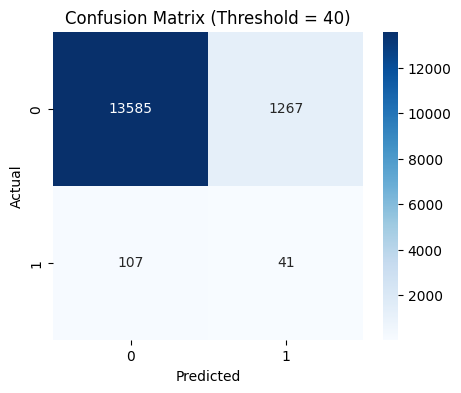

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df["is_fraud"], df["flagged"])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 40)")
plt.show()


### Operational Impact Considerations

- High False Positives → Customer friction, support costs, reputational damage
- High False Negatives → Financial losses, regulatory risk

In banking, thresholds are often tuned based on fraud loss tolerance, regulatory scrutiny, and customer experience priorities.


## 7. Conclusion and Next Steps

This project demonstrates a complete fraud analytics workflow using synthetic transaction data. A rule-based model provides transparency and interpretability but shows limited precision under class imbalance conditions.

Future improvements could include:

- Logistic regression or gradient boosting models
- ROC curve and AUC evaluation
- Cost-sensitive learning approaches
- Threshold optimization using business loss functions
- Feature importance analysis

In real-world banking environments, fraud models are continuously monitored and recalibrated to adapt to evolving fraud patterns.
